# Lending Club Project
### What is the impact of using biased data when Predicting Probability of Default?


### 0. Introduction 

#### Lending Club
Lending Club (LC) is the world's largest Peer-to-Peer (P2P) lending company, headquartered in San Francisco, California. Lending Club operates an online lending platform that enables borrowers to obtain a loan, and investors to purchase notes backed by payments made on loans.

Some highlights of LC loans
* Unsecured loans, between 1k and 40k USD
* Three year or five year loans, although mostly Three year

Source: Wikipedia, https://en.wikipedia.org/wiki/Lending_Club

#### Project Motivation
In order to manage the risk of potential borrowers, lenders typically have approval and rejection policies to screen their applicants. In addition, it is not unsual for financial firms to have their own, proprietary algorithm to assess and price the credit risk.

Lending Club publicly makes available information about both the approved and rejected applications. For the booked applications, this includes credit bureau data at the time of application, loan attributes, and also the performance of the loan, such as whether it fully paid off or defaulted. 

Using this data, it is possible to develop a default prediction model. Could we also use the data provided on the rejected loans to develop a stronger model? Are we underestimating the risk of certain segments by removing the data from the riskiest applications? The challenge is that, since these riskiest loans were never booked, whether the loan would have defaulted or not is unknown.

In industry, there is no consensus on how to handle this situation. Some well established firms choose to ignore this issue, while many large lenders and credit bureau agencencies, as well as FICO, use propreitary techniques to adjust this potential bias via Reject Inference.


#### General Approach
1. Conduct some basic data exploration. What percent of the population is rejected? How does the loan portfolio look like over time?

2. Develop a Probability of Default (PD) model on all the booked loans

3. Attempt to identify Lending Club's auto-reject policies

4. Score the Rejected loans with this model, excluding those that are policy rejects. Simulate Good/Bad on these loans

5. Develop a PD Model with both the Booked and the Simulated Rejects

6. Test the models developed on a holdout sample

In [280]:
#data handling, model creation/evaluation
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
from sklearn.metrics import roc_curve, auc
from matplotlib.ticker import FuncFormatter
import matplotlib
import matplotlib.pyplot as plt
from sklearn.grid_search import GridSearchCV

#make it so that we only show first 4 decimals for floats
np.set_printoptions(precision=4,suppress=True)

# visualization
%matplotlib inline
import seaborn as sns

# http://analytics.ncsu.edu/sesug/2008/ST-160.pdf

/Users/renkohkato/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/renkohkato/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### 1. Importing Data
Here two csvs are imported. The 'LoanStats.csv' includes data for Approved Lending Club Loans, while the 'rejected_2007_to_2016.csv' file includes those that are rejected.

Note on the window of applications:
* Rejected Loans from May 2007 to June 2016
* Booked Loans from to May 2007 through April 2014

In [2]:
# Import Accept data
AcceptData_Raw = pd.read_csv("../LendingClub/data/LoanStats.csv", skiprows=1, low_memory=False)

# Import Reject data
#https://web.archive.org/web/20111101213447/https://www.lendingclub.com/info/download-data.action
RejData_Raw = pd.read_csv("../LendingClub/data/rejected_2007_to_2016.csv")

In [201]:
# Create a copy of the dataset to modify, so do not to reimport original df
AcceptData = AcceptData_Raw.copy()
RejData = RejData_Raw.copy()

In [202]:
# Clean Column Names - remove blanks, set lowercase, etc.
AcceptData.columns = AcceptData.columns.str.lower().str.replace(" ","_").str.replace(".","").str.replace("(", "").str.replace(")", "").str.replace("-","")
RejData.columns = RejData.columns.str.lower().str.replace(" ","_").str.replace(".","").str.replace("(", "").str.replace(")", "").str.replace("-","")


In [203]:
# Basically data cleaning for Date Variables
RejData.application_date = pd.to_datetime(RejData.application_date, format="%Y-%m-%d")
AcceptData.application_date = pd.to_datetime(AcceptData.application_date, format="%Y-%m-%d")

print RejData.head()

print RejData.dtypes

   amount_requested application_date                        loan_title  \
0            1000.0       2007-05-26  Wedding Covered but No Honeymoon   
1            1000.0       2007-05-26                Consolidating Debt   
2           11000.0       2007-05-27       Want to consolidate my debt   
3            6000.0       2007-05-27                           waksman   
4            1500.0       2007-05-27                            mdrigo   

   risk_score debttoincome_ratio zip_code state employment_length  policy_code  
0       693.0                10%    481xx    NM           4 years            0  
1       703.0                10%    010xx    MA          < 1 year            0  
2       715.0                10%    212xx    MD            1 year            0  
3       698.0             38.64%    017xx    MA          < 1 year            0  
4       509.0              9.43%    209xx    MD          < 1 year            0  
amount_requested             float64
application_date      datetime64

In [204]:
RejData.columns

Index([u'amount_requested', u'application_date', u'loan_title', u'risk_score',
       u'debttoincome_ratio', u'zip_code', u'state', u'employment_length',
       u'policy_code'],
      dtype='object')

In [205]:
AcceptData.columns

Index([u'loan_id', u'amount_requested', u'amount_funded_by_investors',
       u'interest_rate', u'loan_length', u'application_date',
       u'application_expiration_date', u'issued_date', u'credit_grade',
       u'loan_title', u'loan_purpose', u'loan_description', u'monthly_payment',
       u'status', u'total_amount_funded', u'debttoincome_ratio',
       u'remaining_principal_funded_by_investors',
       u'payments_to_date_funded_by_investors', u'remaining_principal',
       u'payments_to_date', u'recoveries', u'collection_recovery_fee',
       u'screen_name', u'city', u'state', u'home_ownership', u'monthly_income',
       u'fico_range', u'earliest_credit_line', u'open_credit_lines',
       u'total_credit_lines', u'revolving_credit_balance',
       u'revolving_line_utilization', u'inquiries_in_the_last_6_months',
       u'accounts_now_delinquent', u'delinquent_amount',
       u'delinquencies_last_2_yrs', u'months_since_last_delinquency',
       u'public_records_on_file', u'months_since

In [206]:
RejData.shape
RejData.dtypes

amount_requested             float64
application_date      datetime64[ns]
loan_title                    object
risk_score                   float64
debttoincome_ratio            object
zip_code                      object
state                         object
employment_length             object
policy_code                    int64
dtype: object

In [207]:
AcceptData.shape

(329521, 45)

In [208]:
# We will only keep loans of 36 Month terms for full aging

AcceptData.loan_length.value_counts()

36 months    252623
60 months     76897
Name: loan_length, dtype: int64

In [209]:
# Concatenate the Two DFs with Diff Shapes
# First create file indicator with Rej = "Reject"
AcceptData["Rej_Ind"] = 0
RejData["Rej_Ind"] = 1

# stack the DataFrames on top of each other
Full_data = pd.concat([AcceptData, RejData], axis=0)
Full_data.head()

,Rej_Ind,accounts_now_delinquent,amount_funded_by_investors,amount_requested,application_date,application_expiration_date,city,code,collection_recovery_fee,credit_grade,...,remaining_principal_funded_by_investors,revolving_credit_balance,revolving_line_utilization,risk_score,screen_name,state,status,total_amount_funded,total_credit_lines,zip_code
0,0,0.0,800.0,7500.0,2007-06-07,2007-06-21,Attleboro,NaN,0.0,null,...,0.0,4175.0,51.5%,NaN,Kingtrite,MA,Fully Paid,7500.0,8.0,NaN
1,0,0.0,650.0,5000.0,2007-06-12,2007-06-26,Rockville,NaN,0.0,null,...,0.0,85607.0,0.7%,NaN,Laguna,MD,Fully Paid,5000.0,26.0,NaN
2,0,0.0,1325.0,5000.0,2007-06-12,2007-06-26,Framingham,NaN,0.0,null,...,0.0,9698.0,19.4%,NaN,MGDesousa,MA,Fully Paid,5000.0,20.0,NaN
3,0,0.0,875.0,8500.0,2007-06-13,2007-06-27,Greensboro,NaN,0.0,null,...,0.0,8847.0,26.9%,NaN,Radiothermal,NC,Fully Paid,8500.0,9.0,NaN
4,0,0.0,1075.0,2500.0,2007-06-15,2007-06-29,Lakewood,NaN,0.0,null,...,0.0,7274.0,13.1%,NaN,PMJ7671,CO,Fully Paid,2500.0,40.0,NaN


In [210]:
print "Accept Data shape: ", AcceptData.shape
print "Rej Data shape: ", RejData.shape
print "Combined Data shape: ", Full_data.shape

# sanity check
print "Reject Flag Count: \n", Full_data.Rej_Ind.value_counts()

#vertical_stack.describe()

Accept Data shape:  (329521, 46)
Rej Data shape:  (11079386, 10)
Combined Data shape:  (11408907, 48)
Reject Flag Count: 
1    11079386
0      329521
Name: Rej_Ind, dtype: int64


In [211]:
Full_data["app_year"] = Full_data.application_date.dt.year

In [212]:
Full_data.tail(3)

,Rej_Ind,accounts_now_delinquent,amount_funded_by_investors,amount_requested,application_date,application_expiration_date,city,code,collection_recovery_fee,credit_grade,...,revolving_credit_balance,revolving_line_utilization,risk_score,screen_name,state,status,total_amount_funded,total_credit_lines,zip_code,app_year
11079383,1,NaN,NaN,1200.0,2016-12-31,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,686.0,NaN,CA,NaN,NaN,NaN,914xx,2016.0
11079384,1,NaN,NaN,25000.0,2016-12-31,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NM,NaN,NaN,NaN,880xx,2016.0
11079385,1,NaN,NaN,15000.0,2016-12-31,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,684.0,NaN,NY,NaN,NaN,NaN,113xx,2016.0


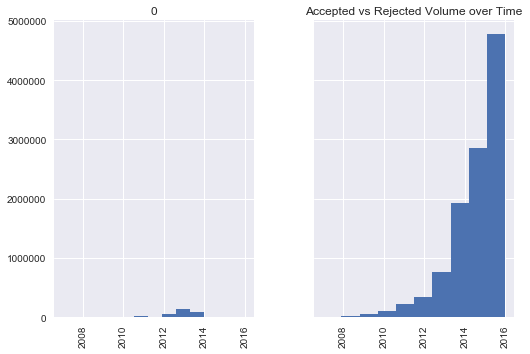

In [213]:
# Plot simple histogram of App Dates by Accept/Reject



In [216]:
# Number of Applications over time
Full_data.app_year.value_counts(dropna=False)

 2016.0    4769874
 2015.0    2859379
 2014.0    2021464
 2013.0     904903
 2012.0     391592
 2011.0     240180
 2010.0     125274
 2009.0      62297
 2008.0      27974
 2007.0       5969
NaN              1
Name: app_year, dtype: int64

In [217]:
Full_data.app_year.value_counts(normalize=True)

2016.0    0.418083
2015.0    0.250627
2014.0    0.177183
2013.0    0.079315
2012.0    0.034323
2011.0    0.021052
2010.0    0.010980
2009.0    0.005460
2008.0    0.002452
2007.0    0.000523
Name: app_year, dtype: float64

### Initial Comments
We can see that the number of loans has grown steadily year-by-year. Also, the number of rejected loans significantly outnumber the number of booked loans. In this dataset over 90% of loans are rejected!

In [17]:
AcceptData.application_date.describe()

count                  329520
unique                   2488
top       2014-04-15 00:00:00
freq                     1478
first     2007-05-25 00:00:00
last      2014-04-30 00:00:00
Name: application_date, dtype: object

In [18]:
RejData.application_date.describe()

count                11079386
unique                   3508
top       2016-07-05 00:00:00
freq                    31010
first     2007-05-26 00:00:00
last      2016-12-31 00:00:00
Name: application_date, dtype: object

In [21]:
# The most recent booked application is in April 30, 2014
# Since we are interested in default data we remove those accounts that have not properly aged

# Keep accounts that have application date prior to May 2011 (Both accepts and rejects)
# Remove accounts that were 60 month loans

Full_data_slim = Full_data[(Full_data['application_date'] < '2011-05-01') & (Full_data['loan_length'] != '60 months' )]


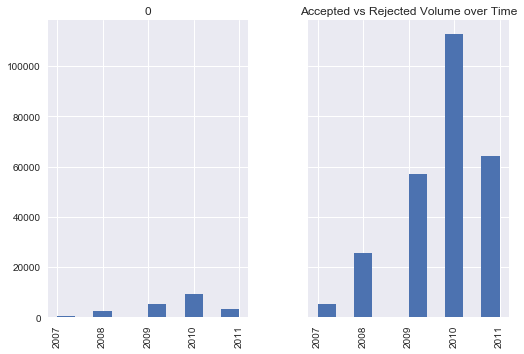

In [218]:
# Plot simple histogram of App Dates by Accept/Reject

Full_data_slim['app_year'].hist(by=Full_data_slim['Rej_Ind'], sharey=True, sharex=True)
sns.plt.title('Accepted vs Rejected Volume over Time')

### Data Exclusions

* Application after 2011 are removed, due to lack of sufficient aging (Loan performance available through 4/2014) 
* For simplicity, loans of 60 months are also excluded, due to long performance required for full aging

In [22]:
print "Loan Length Distribution:\n", Full_data_slim.loan_length.value_counts(dropna=False)

Loan Length Distribution:
NaN          264414
36 months     21109
Name: loan_length, dtype: int64


In [220]:
print "Overall Reject Rate: \n", Full_data_slim.Rej_Ind.value_counts(normalize=True)

Overall Reject Rate: 
1    0.926069
0    0.073931
Name: Rej_Ind, dtype: float64


In [29]:
#############################################
#############################################

Keep = RejData.columns.tolist()
Keep.append("fico_range")
Keep.append("status")

# Keep relevant columns
Full_data_slim2 = Full_data_slim[Keep]

In [30]:
#print Full_data_slim.head(5)
print Full_data_slim.shape

Full_data_slim.status.value_counts(dropna=False)

(285523, 49)


NaN                                                                  264414
Fully Paid                                                            16301
Charged Off                                                            2041
Does not meet the credit policy  Status: Fully Paid                    1786
Does not meet the credit policy  Status: Charged Off                    647
Current                                                                 264
Late (31-120 days)                                                       22
Default                                                                  21
Performing Payment Plan                                                  16
In Grace Period                                                           5
Does not meet the credit policy  Status: Late (31-120 days)               2
Does not meet the credit policy  Status: Performing Payment Plan          2
Late (16-30 days)                                                         1
Does not mee

In [31]:
#Full_data_slim2.dtypes

# Extract bounds from the FICO variable
#Full_data_slim2['fico_l'] = Full_data_slim2.fico_range.str[:3]

Full_data_slim2.loc[:, 'fico_l'] = Full_data_slim2['fico_range'].apply(lambda x: None if x == 'None' else float(str(x)[:3]))
Full_data_slim2.loc[:, 'fico_h'] = Full_data_slim2['fico_range'].apply(lambda x: None if x == 'None' else float(str(x)[-3:]))

#df['Date'].apply(lambda x: int(str(x)[-4:]))
#Full_data_slim2['fico_h'] = Full_data_slim2.fico_range.str[-3:]


In [32]:
# Compute the avg FICO score
Full_data_slim2.loc[:, 'fico_avg'] = Full_data_slim2[['fico_l', 'fico_h']].mean(axis=1)

# Get the final FICO score from the two columns
Full_data_slim2.loc[:, "FICO"] = Full_data_slim2[["fico_avg", "risk_score"]].max(axis=1)

# Convert DTI from String to Float
Full_data_slim2.debttoincome_ratio = pd.Series(Full_data_slim2.debttoincome_ratio).str.replace('%', '').astype(float)


In [33]:
Full_data_slim2.dtypes

amount_requested             float64
application_date      datetime64[ns]
loan_title                    object
risk_score                   float64
debttoincome_ratio           float64
zip_code                      object
state                         object
employment_length             object
policy_code                  float64
Rej_Ind                        int64
fico_range                    object
status                        object
fico_l                       float64
fico_h                       float64
fico_avg                     float64
FICO                         float64
dtype: object

In [34]:
Full_data_slim2.employment_length.value_counts(dropna=False)

< 1 year     150770
10+ years     27144
2 years       21315
1 year        20913
3 years       16419
4 years       12538
5 years       10426
6 years        7374
7 years        5469
8 years        5262
9 years        4389
n/a            3504
Name: employment_length, dtype: int64

In [35]:
# rename DTI column
Full_data_slim2.rename(columns = {'debttoincome_ratio':'dti'}, inplace = True)


/Users/renkohkato/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:2834: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [36]:
# Need to Impute FICO score of 0 and NaN !!!
#Full_data_slim2.FICO.value_counts(dropna=False)


mapp_emp = {
        "10+ years": 10,
        "9 years": 9,
        "8 years": 8,
        "7 years": 7,
        "6 years": 6,
        "5 years": 5,
        "4 years": 4,
        "3 years": 3,
        "2 years": 2,
        "1 year": 1,
        "< 1 year": 0,
        "n/a": 0
    }

mapp_stat = {
        "Fully Paid": 0,
        "Charged Off": 1,
        "Does not meet the credit policy  Status: Fully Paid": 0,
        "Does not meet the credit policy  Status: Charged Off": 1,
        "Current": 0,
        "Late (31-120 days)": 1,
        "Default": 1,
        "Performing Payment Plan": 0,
        "In Grace Period": 0,
        "Does not meet the credit policy  Status: Late (31-120 days)": 1,
        "Does not meet the credit policy  Status: Performing Payment Plan": 0,
        "n/a": 0
    }

Full_data_slim2.loc[:,'emp_length_num'] = Full_data_slim2['employment_length'].map(mapp_emp)

Full_data_slim2.loc[:,'Bad_Ind'] = Full_data_slim2['status'].map(mapp_stat)

# Drop some unneeded Columns
Full_data_slim2 = Full_data_slim2.drop(['fico_l','fico_h', 'fico_range', 'fico_avg', 'policy_code', 'risk_score', 'loan_title', 'zip_code', 'employment_length'], axis=1)

# Clean FICO - with imputation
#Full_data_slim2['FICO'].replace(np.nan, 590,inplace=True)
#Full_data_slim2['FICO'].replace(0, 590,inplace=True)



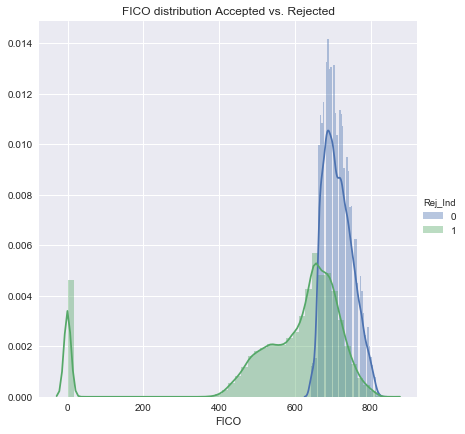

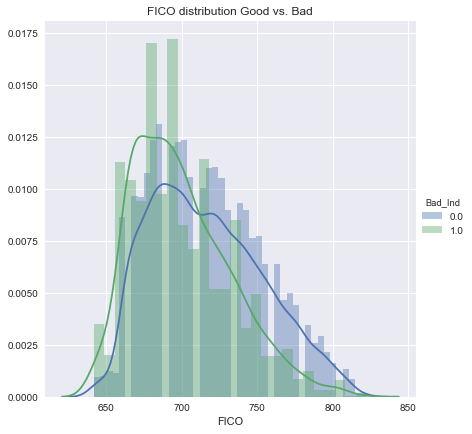

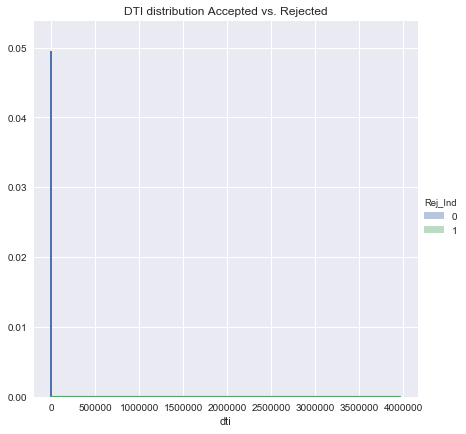

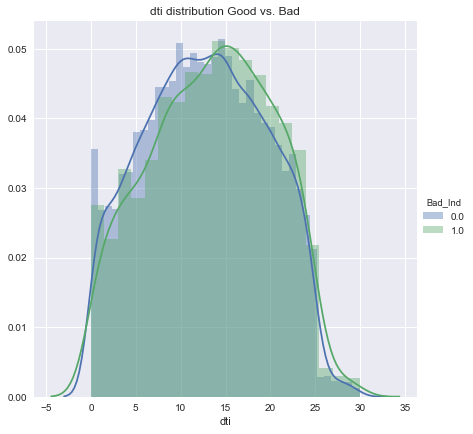

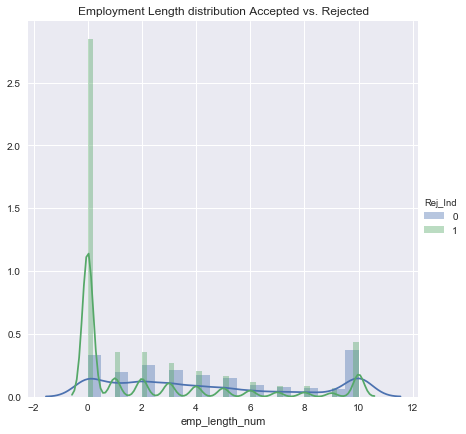

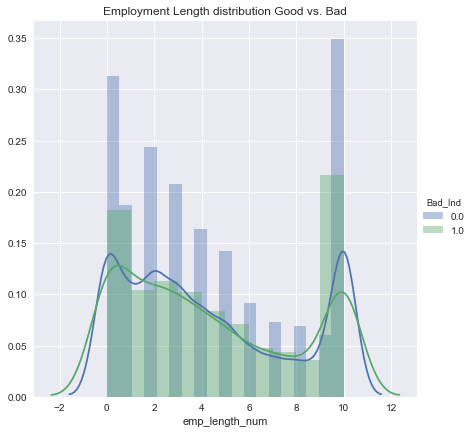

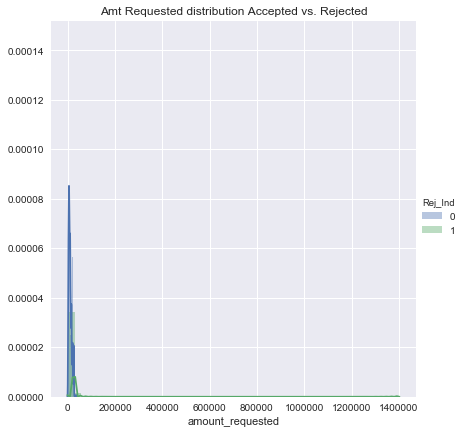

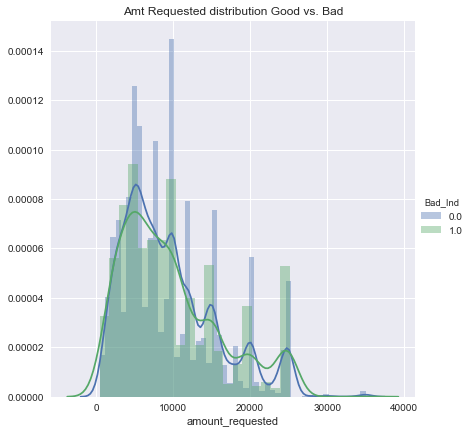

In [66]:

# Distribution of Variables Split by Reject Type
# FICO
g = sns.FacetGrid(Full_data_slim2, hue='Rej_Ind', size=6)
g.map(sns.distplot, "FICO")
g.add_legend()
sns.plt.title('FICO distribution Accepted vs. Rejected')

g2 = sns.FacetGrid(Full_data_slim2, hue='Bad_Ind', size=6)
g2.map(sns.distplot, "FICO")
g2.add_legend()
sns.plt.title('FICO distribution Good vs. Bad')

###########################

# DTI 
g = sns.FacetGrid(Full_data_slim2, hue='Rej_Ind', size=6)
g.map(sns.distplot, "dti")
g.add_legend()
sns.plt.title('DTI distribution Accepted vs. Rejected')

g2 = sns.FacetGrid(Full_data_slim2, hue='Bad_Ind', size=6)
g2.map(sns.distplot, "dti")
g2.add_legend()
sns.plt.title('dti distribution Good vs. Bad')

###########################

# Employment Length
g = sns.FacetGrid(Full_data_slim2, hue='Rej_Ind', size=6)
g.map(sns.distplot, "emp_length_num")
g.add_legend()
sns.plt.title('Employment Length distribution Accepted vs. Rejected')

g2 = sns.FacetGrid(Full_data_slim2, hue='Bad_Ind', size=6)
g2.map(sns.distplot, "emp_length_num")
g2.add_legend()
sns.plt.title('Employment Length distribution Good vs. Bad')


###########################

# Amount Requested
g = sns.FacetGrid(Full_data_slim2, hue='Rej_Ind', size=6)
g.map(sns.distplot, "amount_requested")
g.add_legend()
sns.plt.title('Amt Requested distribution Accepted vs. Rejected')

g2 = sns.FacetGrid(Full_data_slim2, hue='Bad_Ind', size=6)
g2.map(sns.distplot, "amount_requested")
g2.add_legend()
sns.plt.title('Amt Requested distribution Good vs. Bad')


In [64]:
# Describe Accepted Data
print "ACCEPTED DATA: \n", Full_data_slim2.loc[Full_data_slim2['Rej_Ind'] == 0].describe()

# Describe Rejected Data
print "\n \nREJECTED DATA: \n", Full_data_slim2.loc[Full_data_slim2['Rej_Ind'] == 1].describe()

ACCEPTED DATA: 
       amount_requested           dti  Rej_Ind          FICO  emp_length_num  \
count      21109.000000  21109.000000  21109.0  21092.000000    21109.000000   
mean        9568.171159     12.831805      0.0    714.276693        4.368326   
std         6180.452575      6.760578      0.0     37.039572        3.559287   
min          500.000000      0.000000      0.0    642.000000        0.000000   
25%         5000.000000      7.550000      0.0    687.000000        1.000000   
50%         8000.000000     12.890000      0.0    707.000000        3.000000   
75%        12800.000000     18.160000      0.0    742.000000        8.000000   
max        35000.000000     29.960000      0.0    827.000000       10.000000   

            Bad_Ind  
count  21089.000000  
mean       0.129594  
std        0.335864  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000  

 
REJECTED DATA: 
       amount_requested           dti   Rej_In

### Proxy Policy Rejects 
From the charts above, we can approximate proxy rejects for certain atributes. For example, for Accepted Loans, there are no FICO scores below 642, all have a DTI below 30, and all request a loan amount < 35K. Note, there does not appear to be a strict cutoff for employment history, since both accepted and rejected loans can have 0 years of employment.

For loans that fall out of this region, they will be assumed to have been auto-rejected. That is they would not even pass the initial screening, or be run through a Lending Clubs' internal score.

The following will be considered auto-rejects for this study:
* FICO < 640
* DTI >= 30 or DTI < 0
* Amount Requested >= 35k


In [69]:
# Remove Proxy Rejects from Analysis

Full_data_slim3 = Full_data_slim2[(Full_data_slim2['FICO']>= 640) & 
                                  (Full_data_slim2['dti'] < 30) & 
                                  (Full_data_slim2['dti'] >= 0 ) & 
                                  (Full_data_slim2['amount_requested'] < 35000 )]

Full_data_slim3.describe()


,amount_requested,dti,Rej_Ind,FICO,emp_length_num,Bad_Ind
count,101477.000000,101477.000000,101477.000000,101477.000000,101477.000000,21042.000000
mean,11775.408205,13.712977,0.792446,696.428097,2.888507,0.129455
std,7884.060150,8.975495,0.405558,39.447859,3.536429,0.335711
min,500.000000,0.000000,0.000000,640.000000,0.000000,0.000000
25%,5000.000000,5.920000,1.000000,664.000000,0.000000,0.000000
50%,10000.000000,13.380000,1.000000,690.000000,1.000000,0.000000
75%,18000.000000,21.260000,1.000000,722.000000,5.000000,0.000000
max,34800.000000,29.990000,1.000000,832.000000,10.000000,1.000000


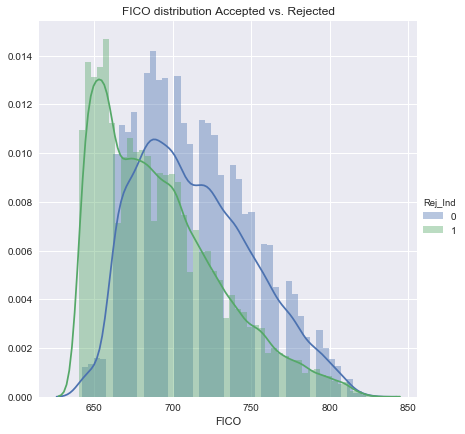

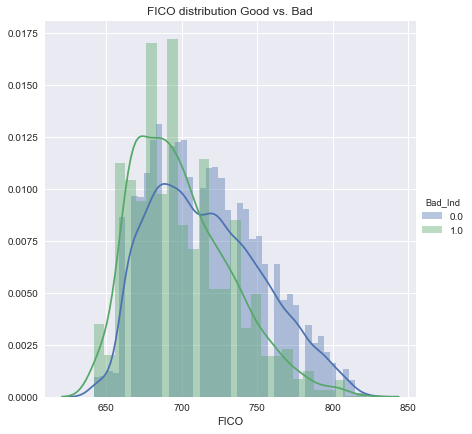

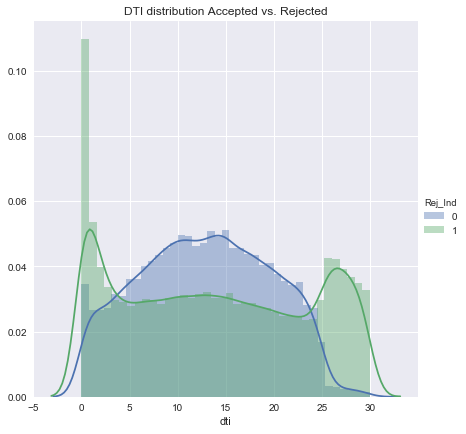

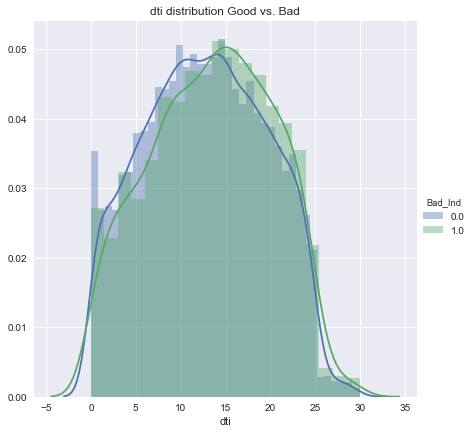

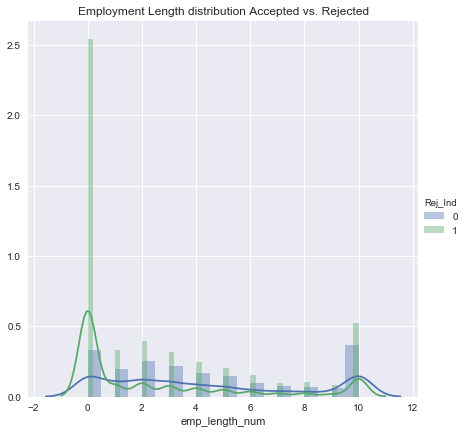

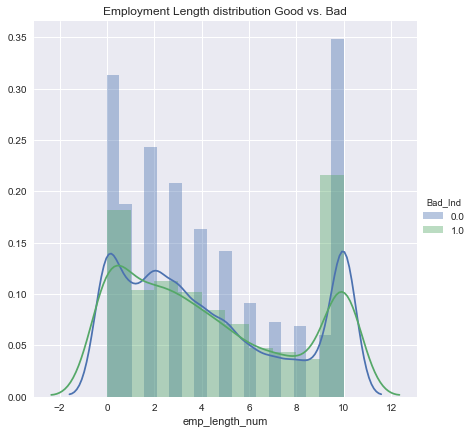

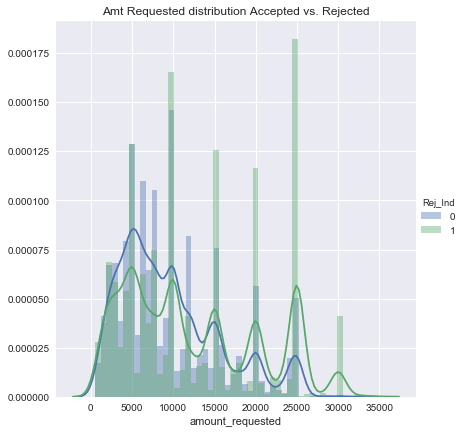

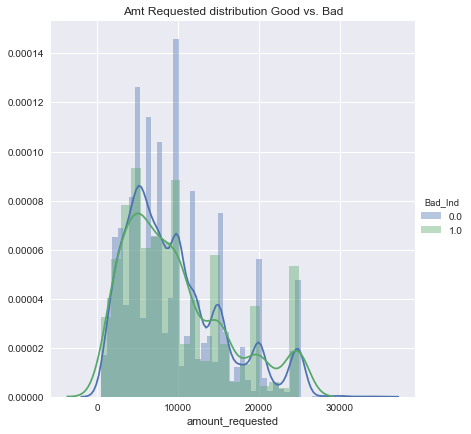

In [70]:

# Distribution of Variables Split by Reject Type
# FICO
g = sns.FacetGrid(Full_data_slim3, hue='Rej_Ind', size=6)
g.map(sns.distplot, "FICO")
g.add_legend()
sns.plt.title('FICO distribution Accepted vs. Rejected')

g2 = sns.FacetGrid(Full_data_slim3, hue='Bad_Ind', size=6)
g2.map(sns.distplot, "FICO")
g2.add_legend()
sns.plt.title('FICO distribution Good vs. Bad')

###########################

# DTI 
g = sns.FacetGrid(Full_data_slim3, hue='Rej_Ind', size=6)
g.map(sns.distplot, "dti")
g.add_legend()
sns.plt.title('DTI distribution Accepted vs. Rejected')

g2 = sns.FacetGrid(Full_data_slim3, hue='Bad_Ind', size=6)
g2.map(sns.distplot, "dti")
g2.add_legend()
sns.plt.title('dti distribution Good vs. Bad')

###########################

# Employment Length
g = sns.FacetGrid(Full_data_slim3, hue='Rej_Ind', size=6)
g.map(sns.distplot, "emp_length_num")
g.add_legend()
sns.plt.title('Employment Length distribution Accepted vs. Rejected')

g2 = sns.FacetGrid(Full_data_slim3, hue='Bad_Ind', size=6)
g2.map(sns.distplot, "emp_length_num")
g2.add_legend()
sns.plt.title('Employment Length distribution Good vs. Bad')


###########################

# Amount Requested
g = sns.FacetGrid(Full_data_slim3, hue='Rej_Ind', size=6)
g.map(sns.distplot, "amount_requested")
g.add_legend()
sns.plt.title('Amt Requested distribution Accepted vs. Rejected')

g2 = sns.FacetGrid(Full_data_slim3, hue='Bad_Ind', size=6)
g2.map(sns.distplot, "amount_requested")
g2.add_legend()
sns.plt.title('Amt Requested distribution Good vs. Bad')


In [78]:
print "Reject Percent (after removing auto-rejects): \n\n", Full_data_slim3.Rej_Ind.value_counts(normalize=True)

print "\n\n Bad Percent: \n", Full_data_slim3.Bad_Ind.value_counts(normalize=True)

Reject Percent (after removing auto-rejects): 

1    0.792446
0    0.207554
Name: Rej_Ind, dtype: float64


 Bad Percent: 
0.0    0.870545
1.0    0.129455
Name: Bad_Ind, dtype: float64


After removing the proxy rejects, FICO and DTI seem to differentiate the best between the Good and Bad, booked
accounts, although not substantially.
Also, the proportion of Rejected Accounts has dropped from approx. 90% to 80%.

In [81]:
#Full_data_slim2.stat_clean.value_counts(dropna=False)

#CrossT = pd.crosstab(index=Full_data_slim2["status"], 
#                    columns=Full_data_slim2["Bad_Ind"], margins=True, dropna=False)
#CrossT

Full_data_slim3.columns

Index([u'amount_requested', u'application_date', u'dti', u'state', u'Rej_Ind',
       u'status', u'FICO', u'emp_length_num', u'Bad_Ind'],
      dtype='object')

### Creating a holdout sample (40 percent)

In [246]:
# Create train and holdout data
# Train & Test

keep_cols = ['FICO', 'dti', 'amount_requested', 'emp_length_num', 'Bad_Ind', 'Rej_Ind'] 

X = Full_data_slim3[keep_cols]
y = Full_data_slim3.Bad_Ind

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=123, stratify=Full_data_slim3.Rej_Ind)


In [247]:
# Double Check Target Rate in Train vs Holdout
print "Train Target Pct\n", y_train.value_counts(dropna=False, normalize=True)

print "\nHold-out Target Pct\n", y_test.value_counts(dropna=False, normalize=True)

Train Target Pct
NaN     0.792646
 0.0    0.180648
 1.0    0.026706
Name: Bad_Ind, dtype: float64

Hold-out Target Pct
NaN     0.792636
 0.0    0.180200
 1.0    0.027165
Name: Bad_Ind, dtype: float64


### Data Prep for building PD Model on the Booked Data

In [248]:
# Filter data for Target Populated
# Booked w/ Performance
ModelDataAccept = X_train[(X_train['Bad_Ind'] >= 0)]

#Non Booked Data (May include Not Taken Ups)
ModelDataRej = X_train[(pd.isnull(X_train.Bad_Ind))]

#ModelDataAccept.describe()

In [249]:
print "Full Training Data", X_train.shape
print "Accept Data", ModelDataAccept.shape
print "Rej Data", ModelDataRej.shape

#ModelDataRej.tail()
#ModelDataRej.FICO.value_counts(dropna=False)

Full Training Data (71033, 6)
Accept Data (14729, 6)
Rej Data (56304, 6)


In [250]:
# 'FICO', 'debttoincome_ratio', 'emp_length_num'
#sns.plt.hist(ModelDataRej.debttoincome_ratio)

ModelDataAccept.dti.describe()

count    14729.000000
mean        12.828589
std          6.756535
min          0.000000
25%          7.560000
50%         12.900000
75%         18.160000
max         29.960000
Name: dti, dtype: float64

In [251]:
#Variable Avg by Good/Bad
ModelDataAccept.groupby('Bad_Ind').mean()


,FICO,dti,amount_requested,emp_length_num,Rej_Ind
Bad_Ind,,,,,
0.0,716.336814,12.733356,9495.269638,4.349283,0.0
1.0,699.332630,13.472778,9762.282551,4.354244,0.0


In [252]:
# Good Rate for Booked Accounts
ModelDataAccept.Bad_Ind.value_counts(normalize=True, dropna=False)

0.0    0.871206
1.0    0.128794
Name: Bad_Ind, dtype: float64

In [289]:
#outcome_pred = logreg.predict(X)
#y_pred = np.where(outcome_pred_class_log >= 0.18, 1, 0)

#print "Model accuracy:", metrics.accuracy_score(y, y_pred)
#print "Model ROC: ", metrics.classification_report(y, y_pred) 

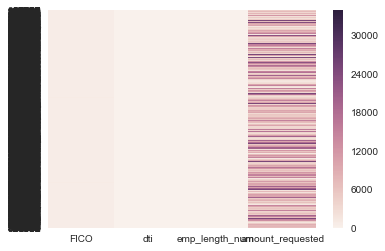

In [299]:
plot_cols = ['FICO', 'dti', 'emp_length_num', 'amount_requested']
sns.heatmap(ModelDataAccept[plot_cols])

### Build a PD Model on the BOOKED Only
#### Logistic Regression and Random Forest

In [254]:
# Fit a logistic regression Model
logreg = LogisticRegression(C=1e9)

# 'amount_requested'
#feature_cols = ['FICO', 'dti', 'emp_length_num', 'amount_requested']
feature_cols = ['FICO', 'dti' , 'emp_length_num']
X_V1 = ModelDataAccept[feature_cols]
y_V1 = ModelDataAccept.Bad_Ind

logreg.fit(X_V1, y_V1)
# store the predicted probabilities
predicted_logreg = logreg.predict_proba(X_V1)[:, 1]

# evaluate the model using 10-fold cross-validation
scores = cross_val_score(logreg, X_V1, y_V1, scoring='accuracy', cv=5)

print scores
print "10 Fold Cross Validation, Avg Score:", scores.mean()

logreg.fit(X_V1, y_V1)
print "\n Parameters: \n", logreg.coef_

print "\n Avg. Predicted Default Prob:", 1 - logreg.predict_proba(X_V1)[:, 1].mean()

[ 0.8711  0.8711  0.8713  0.8713  0.8713]
10 Fold Cross Validation, Avg Score: 0.8712065045

 Parameters: 
[[-0.0047  0.0154  0.0088]]

 Avg. Predicted Default Prob: 0.872816365926


In [285]:
# use GridSearchCV to automate the search across depths 1-10
rf_grid = RandomForestClassifier(n_estimators=50, random_state=1, n_jobs=-1) #50 trees
max_depth_range = range(1, 10)
param_grid = dict(max_depth = max_depth_range)

print param_grid
grid = GridSearchCV(rf_grid, param_grid, cv=10, scoring='accuracy')
grid.fit(X_V1, y_V1)

# store the results of the grid search
grid.grid_scores_
grid_mean_scores = [result.mean_validation_score for result in grid.grid_scores_]

{'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9]}


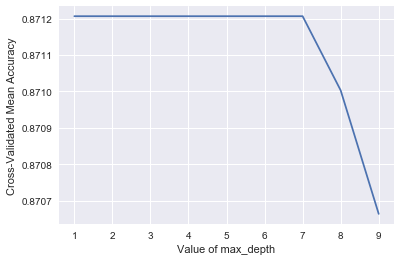

In [286]:
# plot the results
sns.plt.plot(max_depth_range, grid_mean_scores)
sns.plt.xlabel('Value of max_depth')
sns.plt.ylabel('Cross-Validated Mean Accuracy')



In [287]:
# Fitting Random Forest
rf_model = RandomForestClassifier(max_depth=3, random_state=120, n_estimators = 100)

# print "Train accuracy: ", metrics.accuracy_score(y_V1, rf_model.predict(X_V1))

#### Cross Validation
cross_val_scores_RF = cross_val_score(rf_model, X_V1, y_V1, cv=10)
print "10-fold accuracies:\n", cross_val_scores_RF
print "Mean cv-accuracy:", np.mean(cross_val_scores_RF)

rf_model.fit(X_V1, y_V1)
predicted_probs_rf = rf_model.predict_proba(X_V1)[:, 1]

10-fold accuracies:
[ 0.8711  0.8711  0.871   0.871   0.871   0.871   0.871   0.8716  0.8716
  0.8716]
Mean cv-accuracy: 0.871206558838


In [288]:
print "Logistic model AUC: ", metrics.roc_auc_score(y_V1, predicted_logreg)
print "Random Forest model AUC: ", metrics.roc_auc_score(y_V1, predicted_probs_rf)


Logistic model AUC:  0.618446203778
Random Forest model AUC:  0.643790846585


In [300]:
#generate lr model false positive and true positive rates
fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(y_V1, predicted_logreg[:,1])

#generate same for random forest model
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(y_V1, predicted_probs_rf[:,1])

# plot LR and RF model ROC curves
sns.plt.plot(fpr_lr, tpr_lr,label="lr")
sns.plt.plot(fpr_rf, tpr_rf,label="rf")
sns.plt.xlim([0, 1])
sns.plt.ylim([0, 1.05])
sns.plt.legend(loc="lower right")
sns.plt.xlabel('False Positive Rate (1 - Specificity)')
sns.plt.ylabel('True Positive Rate (Sensitivity)')

IndexError: too many indices for array

In [257]:
# Score the NonBooked Accounts with Logistic Reg
X_rej = ModelDataRej[feature_cols]

print "Avg. PD of NonBooked (Excluding Proxy Rejects)", logreg.predict_proba(X_rej)[:, 1].mean()
print "Avg. PD of Booked", logreg.predict_proba(X_V1)[:, 1].mean()

Avg. PD of NonBooked (Excluding Proxy Rejects) 0.139522769734
Avg. PD of Booked 0.127183634074


(array([   20.,    86.,   170.,   222.,   321.,   423.,   544.,   616.,
          708.,   856.,   889.,   946.,  1093.,  1122.,  1083.,  1029.,
         1027.,   856.,   761.,   599.,   471.,   323.,   247.,   149.,
           85.,    44.,    18.,    11.,     5.,     5.]),
 array([ 0.0646,  0.0693,  0.074 ,  0.0787,  0.0834,  0.0881,  0.0928,
         0.0976,  0.1023,  0.107 ,  0.1117,  0.1164,  0.1211,  0.1258,
         0.1305,  0.1353,  0.14  ,  0.1447,  0.1494,  0.1541,  0.1588,
         0.1635,  0.1683,  0.173 ,  0.1777,  0.1824,  0.1871,  0.1918,
         0.1965,  0.2012,  0.206 ]),
 <a list of 30 Patch objects>)

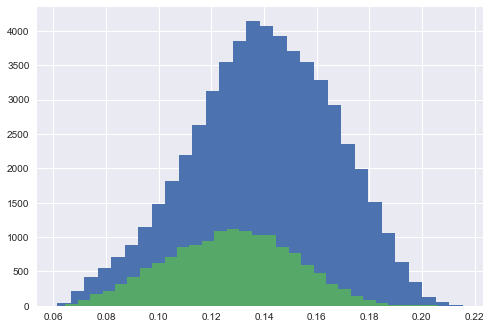

In [258]:
# Histogram of Probabilities
Rej_Pred = logreg.predict_proba(X_rej)[:, 1]
Accept_Pred = logreg.predict_proba(X_V1)[:, 1]

sns.plt.hist(Rej_Pred, bins=30)
sns.plt.hist(Accept_Pred, bins=30)


### Score the NonBooked

In [259]:
# Append PD to Dataset. Note: Here we predict the PDs of the NonBooked
ModelDataRej.loc[:,"PD_RF"]    = rf_model.predict_proba(X_rej)[:, 1]
ModelDataAccept.loc[:,"PD_RF"] = rf_model.predict_proba(X_V1)[:, 1]

ModelDataRej.loc[:,"PD_LR"]    = logreg.predict_proba(X_rej)[:, 1]
ModelDataAccept.loc[:,"PD_LR"] = logreg.predict_proba(X_V1)[:, 1]


### Plot the predicted PDs vs Predictors

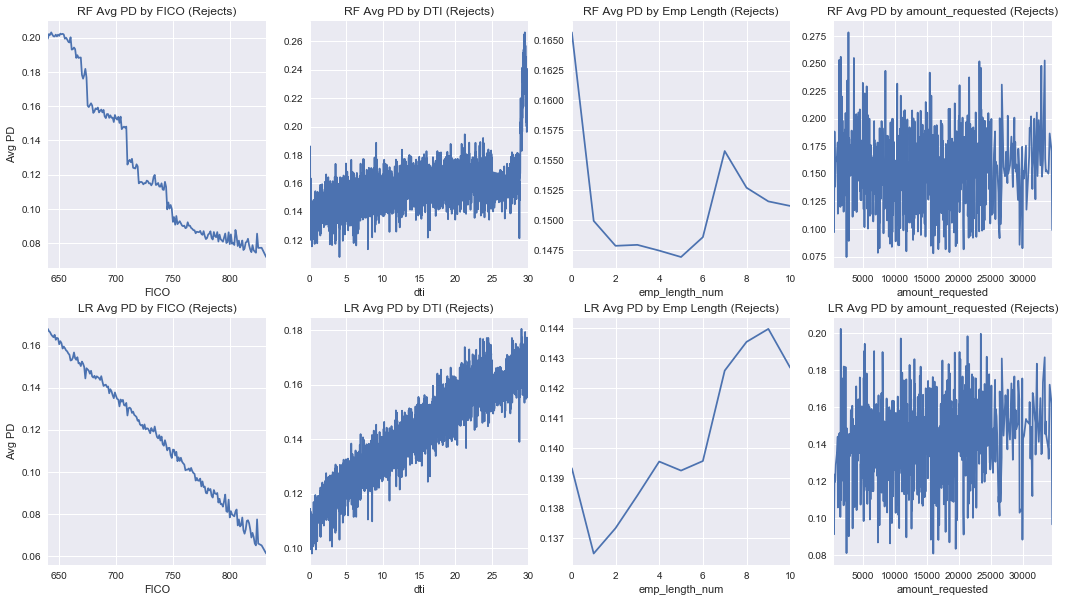

In [260]:


figure = sns.plt.figure(figsize=(18,10))
#add 3 subplots one at a time

#first the component matrix
figure.add_subplot(241)

# Plots by Diff FICO
FICO_rej_grp = ModelDataRej.groupby("FICO")
FICO_Means_Rej = FICO_rej_grp["PD_RF"].agg(np.mean) #3  Mean of Soda Prices

FICO_Means_Rej.plot(title="RF Avg PD by FICO (Rejects)") #5
sns.plt.ylabel("Avg PD") #6

#first the component matrix
figure.add_subplot(242)

# Plots by Diff Groups
FICO_rej_grp = ModelDataRej.groupby("dti")
FICO_Means_Rej = FICO_rej_grp["PD_RF"].agg(np.mean) #3  Mean of Soda Prices

FICO_Means_Rej.plot(title="RF Avg PD by DTI (Rejects)") #5


#first the component matrix
figure.add_subplot(243)

# Plots by Diff Groups
FICO_rej_grp = ModelDataRej.groupby("emp_length_num")
FICO_Means_Rej = FICO_rej_grp["PD_RF"].agg(np.mean) #3  Mean of Soda Prices

FICO_Means_Rej.plot(title="RF Avg PD by Emp Length (Rejects)") #5


#first the component matrix
figure.add_subplot(244)

# Plots by Diff Groups
FICO_rej_grp = ModelDataRej.groupby("amount_requested")
FICO_Means_Rej = FICO_rej_grp["PD_RF"].agg(np.mean) #3  Mean of Soda Prices

FICO_Means_Rej.plot(title="RF Avg PD by amount_requested (Rejects)") #5


##################################
### Logistic Regression Plots
##################################

#first the component matrix
figure.add_subplot(245)

# Plots by Diff FICO
FICO_rej_grp = ModelDataRej.groupby("FICO")
FICO_Means_Rej = FICO_rej_grp["PD_LR"].agg(np.mean) #3  Mean of Soda Prices

FICO_Means_Rej.plot(title="LR Avg PD by FICO (Rejects)") #5
sns.plt.ylabel("Avg PD") #6



#first the component matrix
figure.add_subplot(246)

# Plots by Diff Groups
FICO_rej_grp = ModelDataRej.groupby("dti")
FICO_Means_Rej = FICO_rej_grp["PD_LR"].agg(np.mean) #3  Mean of Soda Prices

FICO_Means_Rej.plot(title="LR Avg PD by DTI (Rejects)") #5


#first the component matrix
figure.add_subplot(247)

# Plots by Diff Groups
FICO_rej_grp = ModelDataRej.groupby("emp_length_num")
FICO_Means_Rej = FICO_rej_grp["PD_LR"].agg(np.mean) #3  Mean of Soda Prices

FICO_Means_Rej.plot(title="LR Avg PD by Emp Length (Rejects)") #5

#first the component matrix
figure.add_subplot(248)

# Plots by Diff Groups
FICO_rej_grp = ModelDataRej.groupby("amount_requested")
FICO_Means_Rej = FICO_rej_grp["PD_LR"].agg(np.mean) #3  Mean of Soda Prices

FICO_Means_Rej.plot(title="LR Avg PD by amount_requested (Rejects)") #5


### Comments from LR and RF Fit
The overall fit stats for the RF are better. Upon inspection of the Features vs the predicted probabilities, the RF also looks like it makes more sense. The 'pattern' is reversed for the emp_length_num, which is more explainable in the RF model.


In [198]:
# http://stackoverflow.com/questions/3866520/plotting-histograms-whose-bar-heights-sum-to-1-in-matplotlib/16399202#16399202

#####ModelDataRej.hist(bins=20, weights=np.ones_like(ModelDataRej[ModelDataRej.columns[0]]) * 100. / len(ModelDataRej))

#weights_Rej = np.ones_like(ModelDataRej.PD)/len(ModelDataRej.PD)
#weights_Acc = np.ones_like(ModelDataAccept.PD)/len(ModelDataAccept.PD)

#sns.plt.hist(ModelDataRej.PD, weights=weights_Rej, bins=10)
#sns.plt.hist(ModelDataAccept.PD, weights=weights_Acc, bins=10)


### Infer Good/Bad of the NonBooked Accounts

In [261]:
# Simulate the Good/Bad in Rejected Data
# For each record, classify if bad if PD_RF is greater than rand [0,1]
ModelDataRej.loc[:, 'Bad_Ind_Inf'] = ModelDataRej['PD_RF'].apply(lambda x: 1 if x > np.random.random_sample() else 0) 

# Sanity Check
ModelDataRej.Bad_Ind_Inf.value_counts(dropna=False, normalize=True)

#ModelDataRej.sort_values(by='PD_RF', ascending=0)

0    0.841823
1    0.158177
Name: Bad_Ind_Inf, dtype: float64

In [262]:
#del ModelDataRej['Rand_Int']

In [263]:
# stack the DataFrames on top of each other
# For NonBooked use PD, for booked, copy Bad_Ind

ModelDataAccept.loc[:, 'Bad_Ind_Inf'] = ModelDataAccept['Bad_Ind']

ModelFull_data = pd.concat([ModelDataAccept, ModelDataRej], axis=0)


In [264]:
print "Reject Inferred Good/Bad: \n", ModelDataRej.Bad_Ind_Inf.value_counts()
print "\nBooked Good/Bad: \n", ModelDataAccept.Bad_Ind.value_counts(normalize=True)

print "\nRej Inferred Bad Rate: \n", ModelDataRej.Bad_Ind_Inf.value_counts(normalize=True)
print "\nBad Rate of Full Dataset: \n", ModelFull_data.Bad_Ind_Inf.value_counts(normalize=True)

Reject Inferred Good/Bad: 
0    47398
1     8906
Name: Bad_Ind_Inf, dtype: int64

Booked Good/Bad: 
0.0    0.871206
1.0    0.128794
Name: Bad_Ind, dtype: float64

Rej Inferred Bad Rate: 
0    0.841823
1    0.158177
Name: Bad_Ind_Inf, dtype: float64

Bad Rate of Full Dataset: 
0.0    0.847916
1.0    0.152084
Name: Bad_Ind_Inf, dtype: float64


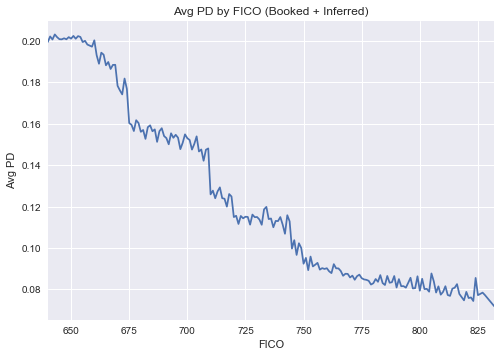

In [265]:
# Plots by Diff Groups
FICO_full_grp = ModelFull_data.groupby("FICO")
FICO_Means_full = FICO_full_grp["PD_RF"].agg(np.mean) #3  Mean of Soda Prices

FICO_Means_full.plot(title="Avg PD by FICO (Booked + Inferred)") #5
sns.plt.ylabel("Avg PD") #6


### Build a PD Model on the BOOKED + REJECTS (inferred performance)
#### Logistic Regression and Random Forest

In [267]:
# Fit a logistic regression Model on Full Data
logreg_Full = LogisticRegression(C=1e9)

#, 'amount_requested'
#feature_cols = ['FICO', 'dti', 'emp_length_num', 'amount_requested']
feature_cols = ['FICO', 'dti', 'emp_length_num']
X_full = ModelFull_data[feature_cols]
y_full = ModelFull_data.Bad_Ind_Inf # Includes Inferred Good/Bad

# store the predicted probabilities
#outcome_pred_prob_log = logreg.predict_proba(X)[:, 1]# evaluate the model using 10-fold cross-validation
scores_full = cross_val_score(LogisticRegression(), X_full, y_full, scoring='accuracy', cv=10)


print scores_full
print "10 Fold Cross Validation, Avg Score:", scores_full.mean()

logreg_Full.fit(X_full, y_full)
predicted_logreg_full = logreg_Full.predict_proba(X_full)[:, 1]

print "\n Parameters: \n", logreg_Full.coef_

print "\n Avg. Predicted Default Prob:", logreg_Full.predict_proba(X_full)[:, 1].mean()

[ 0.8478  0.8478  0.8478  0.848   0.848   0.848   0.848   0.848   0.848
  0.848 ]
10 Fold Cross Validation, Avg Score: 0.847915760994

 Parameters: 
[[-0.0027  0.0103 -0.0131]]

 Avg. Predicted Default Prob: 0.150601383722


In [269]:
# Fitting Random Forest
rf_model_full = RandomForestClassifier(max_depth=3, random_state=120, n_estimators = 100)

rf_model_full.fit(X_full, y_full)
predicted_probs_rf_full = rf_model_full.predict_proba(X_full)[:, 1]

# print "Train accuracy: ", metrics.accuracy_score(y_V1, rf_model.predict(X_V1))

#### Cross Validation
cross_val_scores_RF_Full = cross_val_score(rf_model_full, X_full, y_full, cv=10)
print "10-fold accuracies:\n", cross_val_scores_RF_Full
print "Mean cv-accuracy:", np.mean(cross_val_scores_RF_Full)


10-fold accuracies:
[ 0.8478  0.8478  0.8478  0.848   0.848   0.848   0.848   0.848   0.848
  0.848 ]
Mean cv-accuracy: 0.847915760994


In [270]:
print "Logistic model AUC: ", metrics.roc_auc_score(y_full, predicted_logreg_full)
print "Random Forest model AUC: ", metrics.roc_auc_score(y_full, predicted_probs_rf_full)


Logistic model AUC:  0.577920616839
Random Forest model AUC:  0.602817730896


### Score the NonBooked on Test Data using Model 1

In [271]:
# Predict test dataset - Booked Only
Test_Booked = X_test[(X_test['Bad_Ind'] >= 0)]

#Non Booked Data (May include Not Taken Ups)
Test_Rej = X_test[(pd.isnull(X_test.Bad_Ind))]


In [273]:
#feature_cols = ['FICO', 'dti', 'emp_length_num', 'amount_requested']
feature_cols = ['FICO', 'dti', 'emp_length_num']
X_test_Rej = Test_Rej[feature_cols]

# Score the Rejects using Original RF Model
Test_Rej.loc[:,"PD_RF"]    = rf_model.predict_proba(X_test_Rej)[:, 1]

# For each record, classify if bad if PD_RF is greater than rand [0,1]
Test_Rej.loc[:, 'Bad_Ind_Inf'] = Test_Rej['PD_RF'].apply(lambda x: 1 if x > np.random.random_sample() else 0) 

# Create the same field for the Booked
Test_Booked.loc[:, 'Bad_Ind_Inf'] = Test_Booked['Bad_Ind']

# Sanity Check
Test_Booked.Bad_Ind_Inf.value_counts(dropna=False, normalize=True)

0.0    0.869
1.0    0.131
Name: Bad_Ind_Inf, dtype: float64

In [275]:
# Concatenate the Datasets

Test_Full_data = pd.concat([Test_Booked, Test_Rej], axis=0)

Test_Full_data.Bad_Ind_Inf.value_counts(dropna=False, normalize=True)

0.0    0.846801
1.0    0.153199
Name: Bad_Ind_Inf, dtype: float64

In [277]:
# TEST BOOKED DATA

#feature_cols = ['FICO', 'dti', 'emp_length_num', 'amount_requested']
feature_cols = ['FICO', 'dti', 'emp_length_num']
X_test_data = Test_Booked[feature_cols]
Y_test_data = Test_Booked.Bad_Ind

# LR Predictions
predicted_logreg_test      = logreg.predict_proba(X_test_data)[:, 1]
predicted_logreg_full_test = logreg_Full.predict_proba(X_test_data)[:, 1]

# RF Predictions
predicted_rf_test      = rf_model.predict_proba(X_test_data)[:, 1]
predicted_rf_full_test = rf_model_full.predict_proba(X_test_data)[:, 1]


print "\nTest ROC for Model Booked Only (LR Model): ", metrics.roc_auc_score(Y_test_data, predicted_logreg_test)
print "\nTest ROC for Model Booked and Rejected (LR Model): ", metrics.roc_auc_score(Y_test_data, predicted_logreg_full_test)


print "\nTest ROC for Model Booked Only (RF Model): ", metrics.roc_auc_score(Y_test_data, predicted_rf_test)
print "\nTest ROC for Model Booked and Rejected (RF Model): ", metrics.roc_auc_score(Y_test_data, predicted_rf_full_test)

#print "\nTest accuracy for Model V1: ", metrics.accuracy_score(Y_test_data, logreg.predict(X_test_data))
#print "\nTest accuracy for Model V2: ", metrics.accuracy_score(Y_test_data, logreg_Full.predict(X_test_data))


# Append Predicted PD from Booked LogRegModel
#X_test_data.loc[:,"PD_Booked"] = logreg.predict_proba(X_test_data)[:, 1]


Test ROC for Model Booked Only (LR Model):  0.608046380343

Test ROC for Model Booked and Rejected (LR Model):  0.602274405423

Test ROC for Model Booked Only (RF Model):  0.619875104752

Test ROC for Model Booked and Rejected (RF Model):  0.620997341369


In [278]:
# TEST BOOKED + INFERRED DATA

#feature_cols = ['FICO', 'dti', 'emp_length_num', 'amount_requested']
feature_cols = ['FICO', 'dti', 'emp_length_num']
X_test_full_data = Test_Full_data[feature_cols]
Y_test_full_data = Test_Full_data.Bad_Ind_Inf

# LR Predictions
predicted_logreg_inf_test      = logreg.predict_proba(X_test_full_data)[:, 1]
predicted_logreg_inf_full_test = logreg_Full.predict_proba(X_test_full_data)[:, 1]

# RF Predictions
predicted_rf_inf_test      = rf_model.predict_proba(X_test_full_data)[:, 1]
predicted_rf_full_inf_test = rf_model_full.predict_proba(X_test_full_data)[:, 1]


print "\nTest ROC for Model Booked Only (LR Model1): ", metrics.roc_auc_score(Y_test_full_data, predicted_logreg_inf_test)
print "\nTest ROC for Model Booked and Rejected (LR Model2): ", metrics.roc_auc_score(Y_test_full_data, predicted_logreg_inf_full_test)


print "\nTest ROC for Model Booked Only (RF Model1): ", metrics.roc_auc_score(Y_test_full_data, predicted_rf_inf_test)
print "\nTest ROC for Model Booked and Rejected (RF Model2): ", metrics.roc_auc_score(Y_test_full_data, predicted_rf_full_inf_test)

#print "\nTest accuracy for Model V1: ", metrics.accuracy_score(Y_test_data, logreg.predict(X_test_data))
#print "\nTest accuracy for Model V2: ", metrics.accuracy_score(Y_test_data, logreg_Full.predict(X_test_data))


# Append Predicted PD from Booked LogRegModel
#X_test_data.loc[:,"PD_Booked"] = logreg.predict_proba(X_test_data)[:, 1]


Test ROC for Model Booked Only (LR Model1):  0.583672384719

Test ROC for Model Booked and Rejected (LR Model2):  0.578250917015

Test ROC for Model Booked Only (RF Model1):  0.598276442241

Test ROC for Model Booked and Rejected (RF Model2):  0.59460036817


In [712]:
X_test_final

,FICO,dti,emp_length_num
82996,677.0,69.66,7
77313,604.0,23.72,1
45075,717.0,26.46,3
12719,733.0,270.70,0
11583,641.0,60.03,0
68158,646.0,24.74,3
153503,704.0,5.00,0
54928,743.0,37.71,10
169285,685.0,52.85,0
140377,590.0,-1.00,0
